In [26]:
!pip3 install keras_tuner

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import joblib

In [28]:
PROJECT_PATH='/content/drive/MyDrive/Colab Notebooks/Old-Dataset-Training'
PROJECT_NAME = 'LSTM_Multi-Variable_CPU_Request'

# Parameters
WINDOW_SIZE = 30
FORECAST_HORIZON = 5

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
df = pd.read_csv(PROJECT_PATH+'/LSTM_Ready_Dataset_Old.csv')
df

,timestamp,node_cpu_usage_10.35.29.108:10250,node_cpu_usage_10.35.29.109:10250,node_cpu_usage_10.35.29.110:10250,node_mem_usage_10.35.29.108:10250,node_mem_usage_10.35.29.109:10250,node_mem_usage_10.35.29.110:10250,node_cpu_req_unknown,node_cpu_req_aj-aung-k8s-master,node_cpu_req_aj-aung-k8s-worker1,...,node_mem_req_aj-aung-k8s-master,node_mem_req_aj-aung-k8s-worker1,node_mem_req_aj-aung-k8s-worker2,node_cpu_cap_aj-aung-k8s-master,node_cpu_cap_aj-aung-k8s-worker1,node_cpu_cap_aj-aung-k8s-worker2,node_mem_cap_aj-aung-k8s-master,node_mem_cap_aj-aung-k8s-worker1,node_mem_cap_aj-aung-k8s-worker2,cluster_pods_pending
0,2024-01-01 00:00:00,0.208623,5.975408,0.000000,1922273280,2561769472,0.0,0.2,1.2,3.95,...,461373440.0,2.638217e+09,0.000000e+00,4.0,4.0,0.0,8.332218e+09,8.332227e+09,0.000000e+00,2.0
1,2024-01-01 00:01:00,0.326459,5.980638,0.000000,1930141696,2591625216,0.0,0.8,1.2,3.95,...,461373440.0,2.638217e+09,0.000000e+00,4.0,4.0,0.0,8.332218e+09,8.332227e+09,0.000000e+00,5.0
2,2024-01-01 00:02:00,0.219911,5.765409,1.515837,1926356992,2586947584,374190080.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.149239e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
3,2024-01-01 00:03:00,0.221737,5.879989,2.850323,1940553728,2593882112,388370432.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.417675e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
4,2024-01-01 00:04:00,0.234354,5.842184,4.132435,1887465472,2598359040,400961536.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.820328e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19477,2024-01-14 12:37:00,0.215379,5.160844,5.077805,1995857920,2587627520,409989120.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
19478,2024-01-14 12:38:00,0.200130,5.118348,5.014877,1952833536,2601111552,412585984.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
19479,2024-01-14 12:39:00,0.209720,5.174387,5.084887,1955295232,2584264704,415567872.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
19480,2024-01-14 12:40:00,0.202781,5.333707,5.059837,1951297536,2554994688,416882688.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0


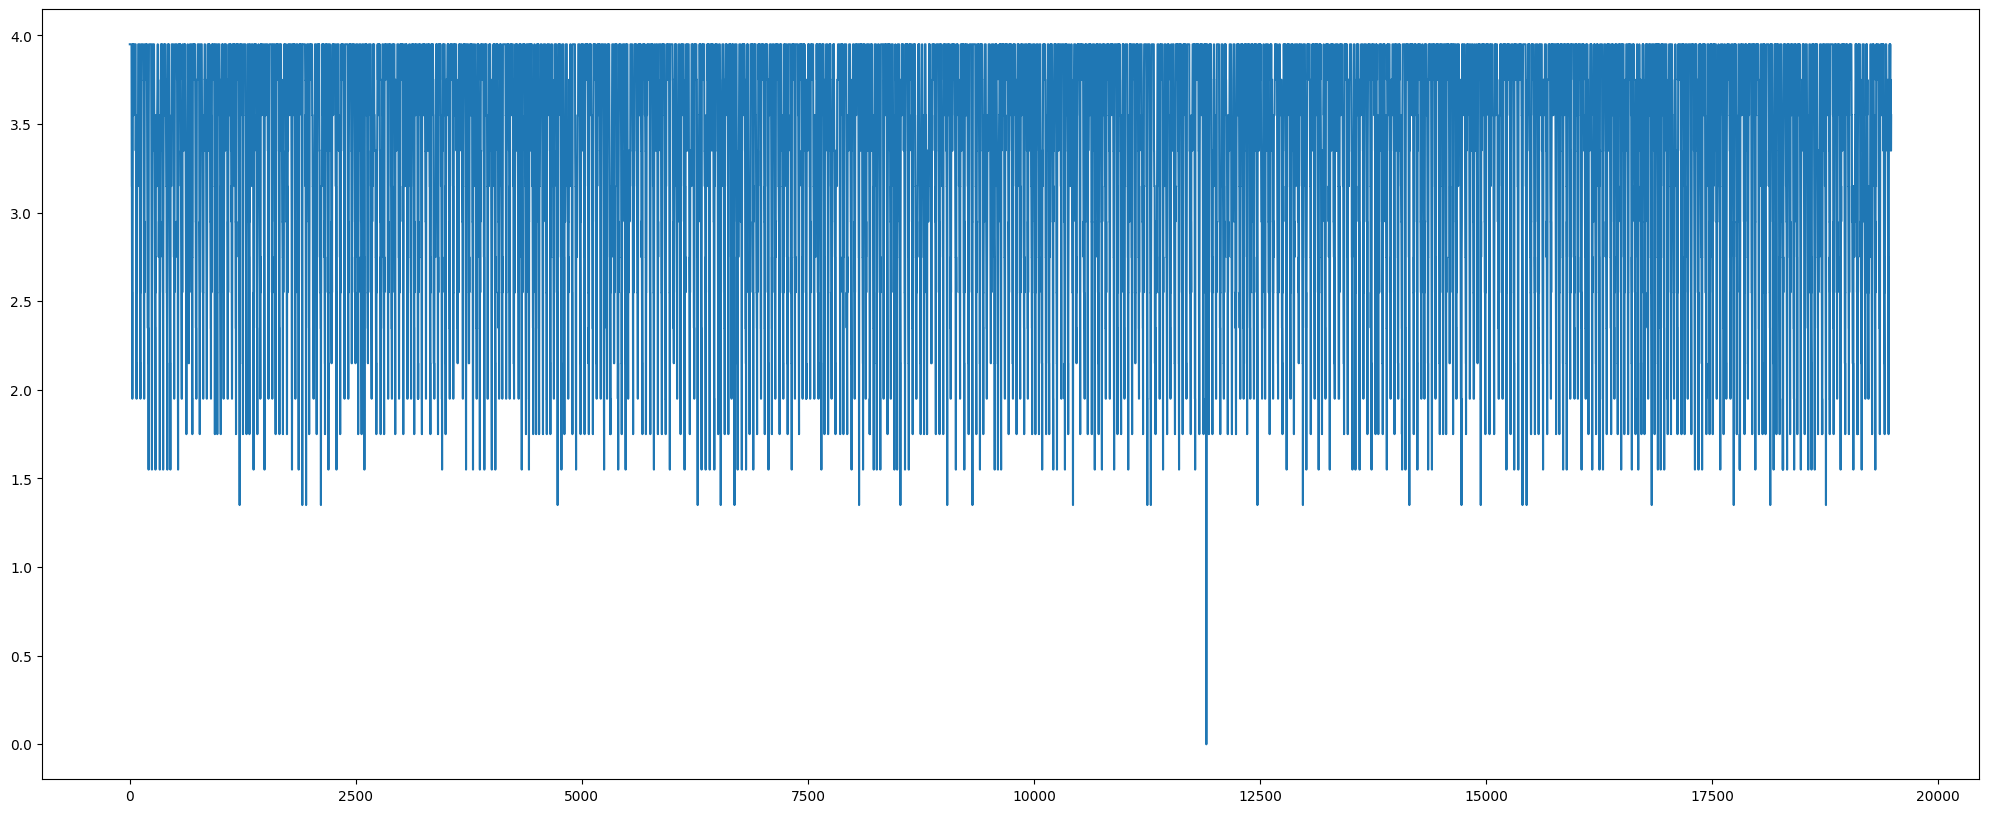

In [31]:
plt.figure(figsize=(25, 10))
plt.plot(df['node_cpu_req_aj-aung-k8s-worker1'])
plt.show()

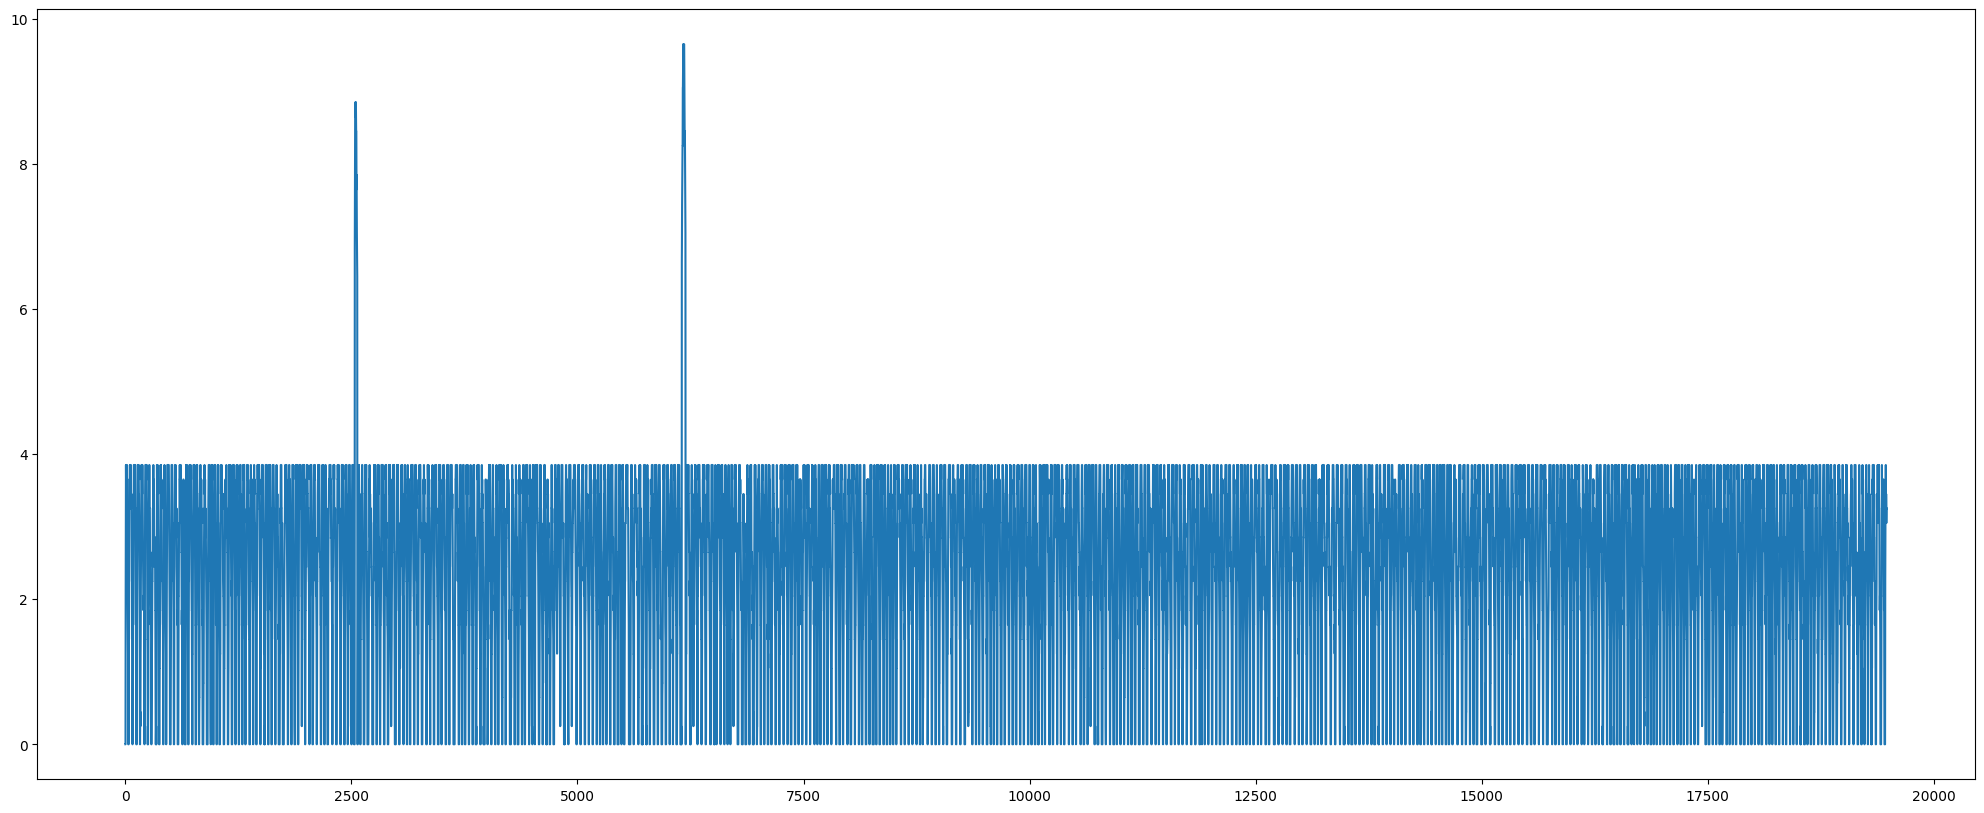

In [32]:
plt.figure(figsize=(25, 10))
plt.plot(df['node_cpu_req_aj-aung-k8s-worker2'])
plt.show()

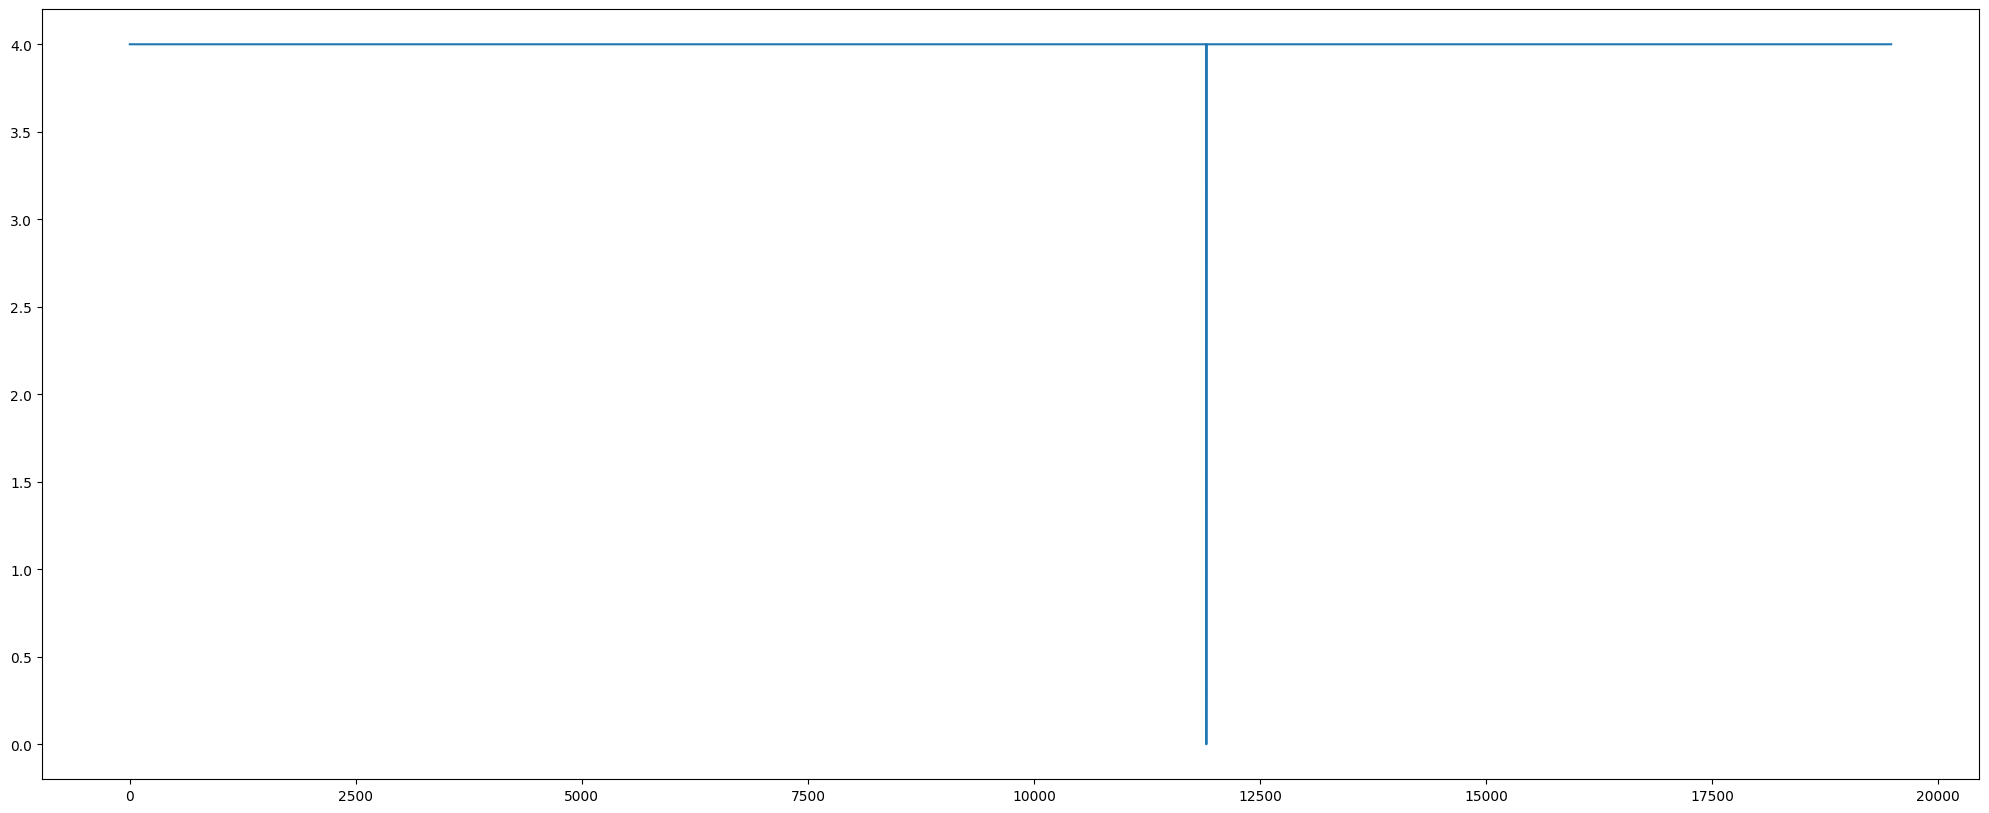

In [33]:
plt.figure(figsize=(25, 10))
plt.plot(df['node_cpu_cap_aj-aung-k8s-worker1'])
plt.show()

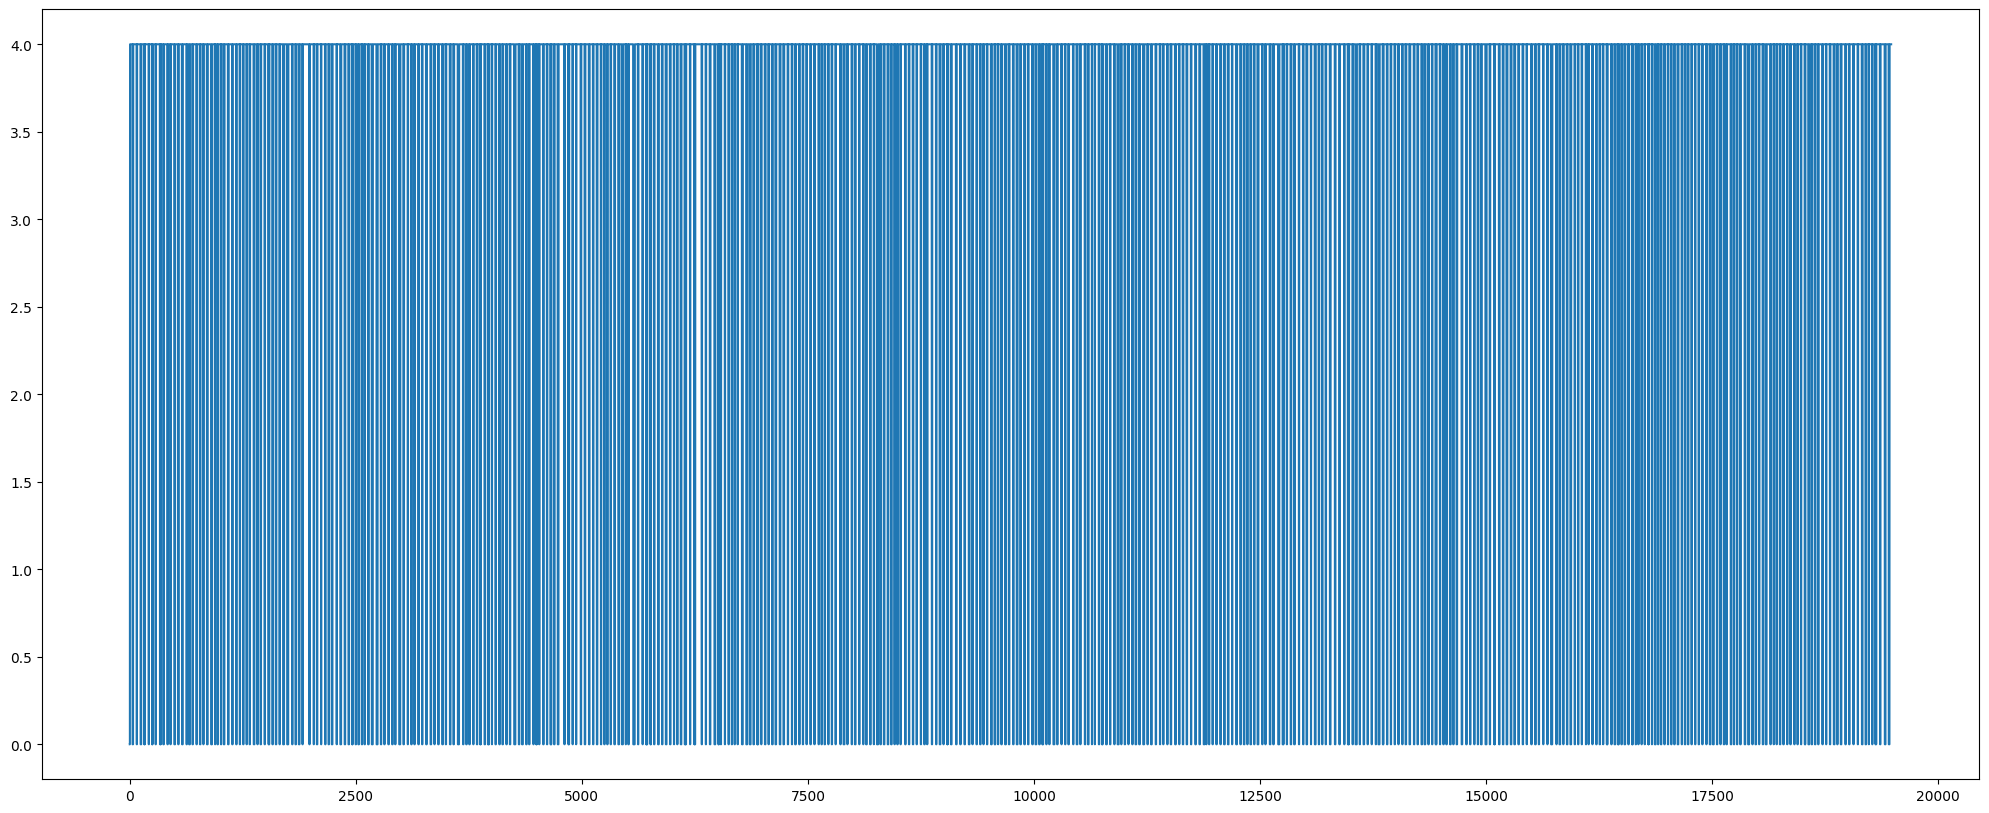

In [34]:
plt.figure(figsize=(25, 10))
plt.plot(df['node_cpu_cap_aj-aung-k8s-worker2'])
plt.show()

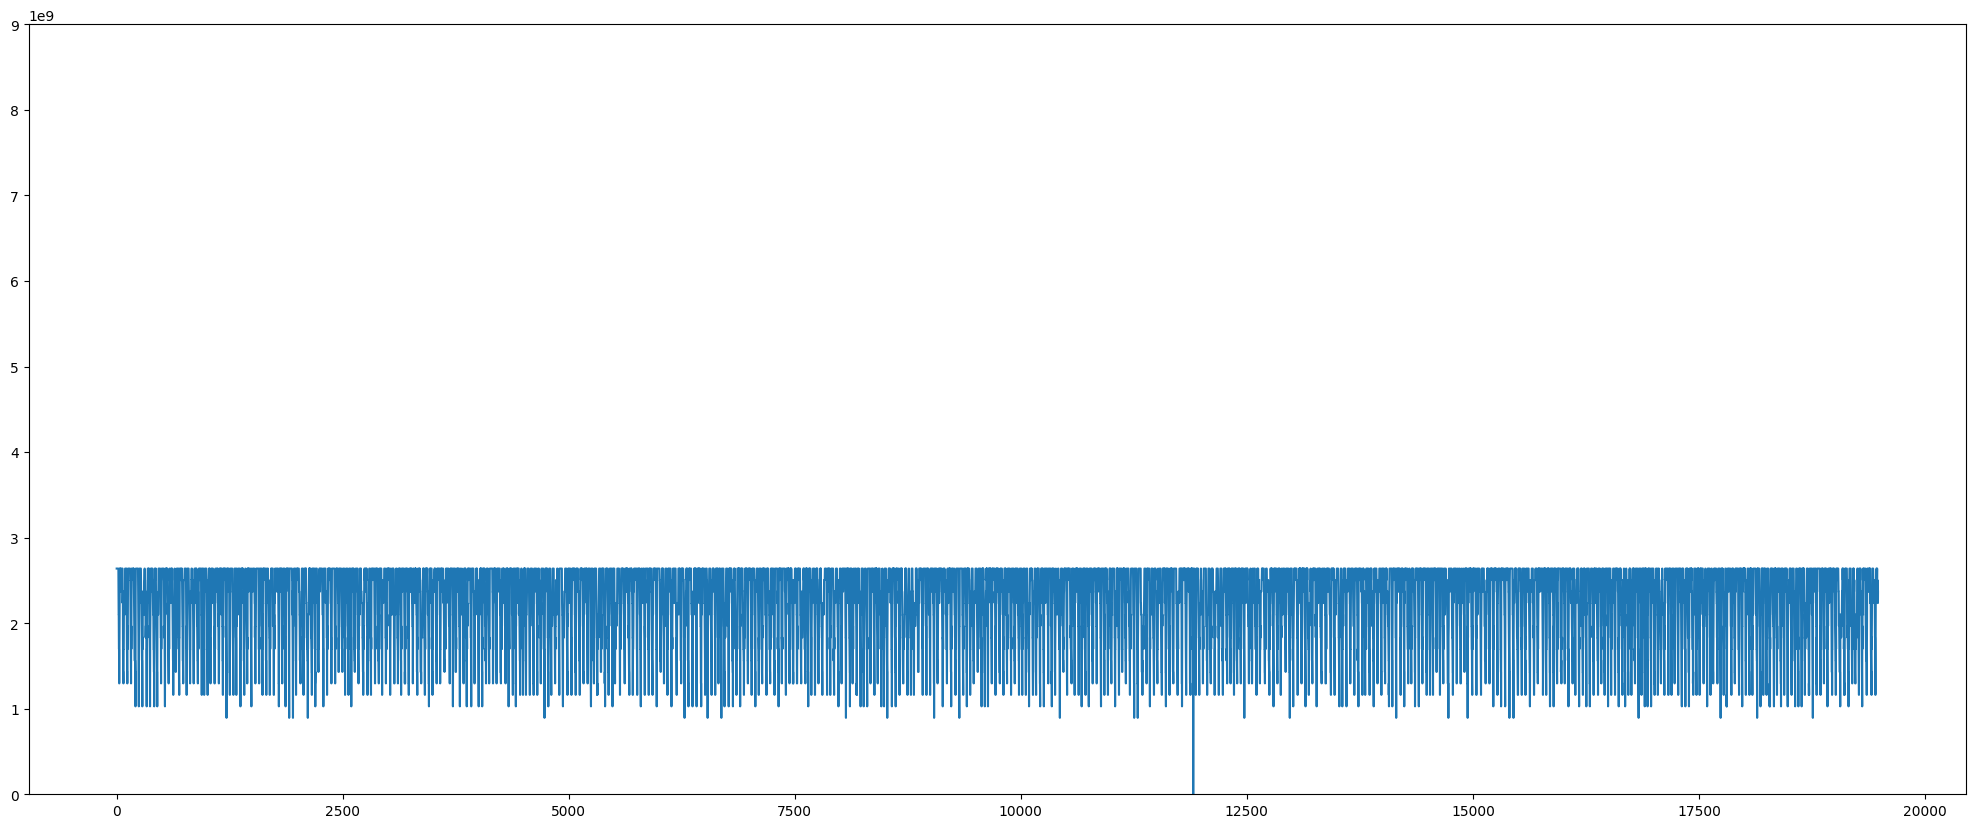

In [35]:
plt.figure(figsize=(25, 10))
plt.plot(df['node_mem_req_aj-aung-k8s-worker1'])
plt.ylim(0, (9 * (10**9)))
plt.show()

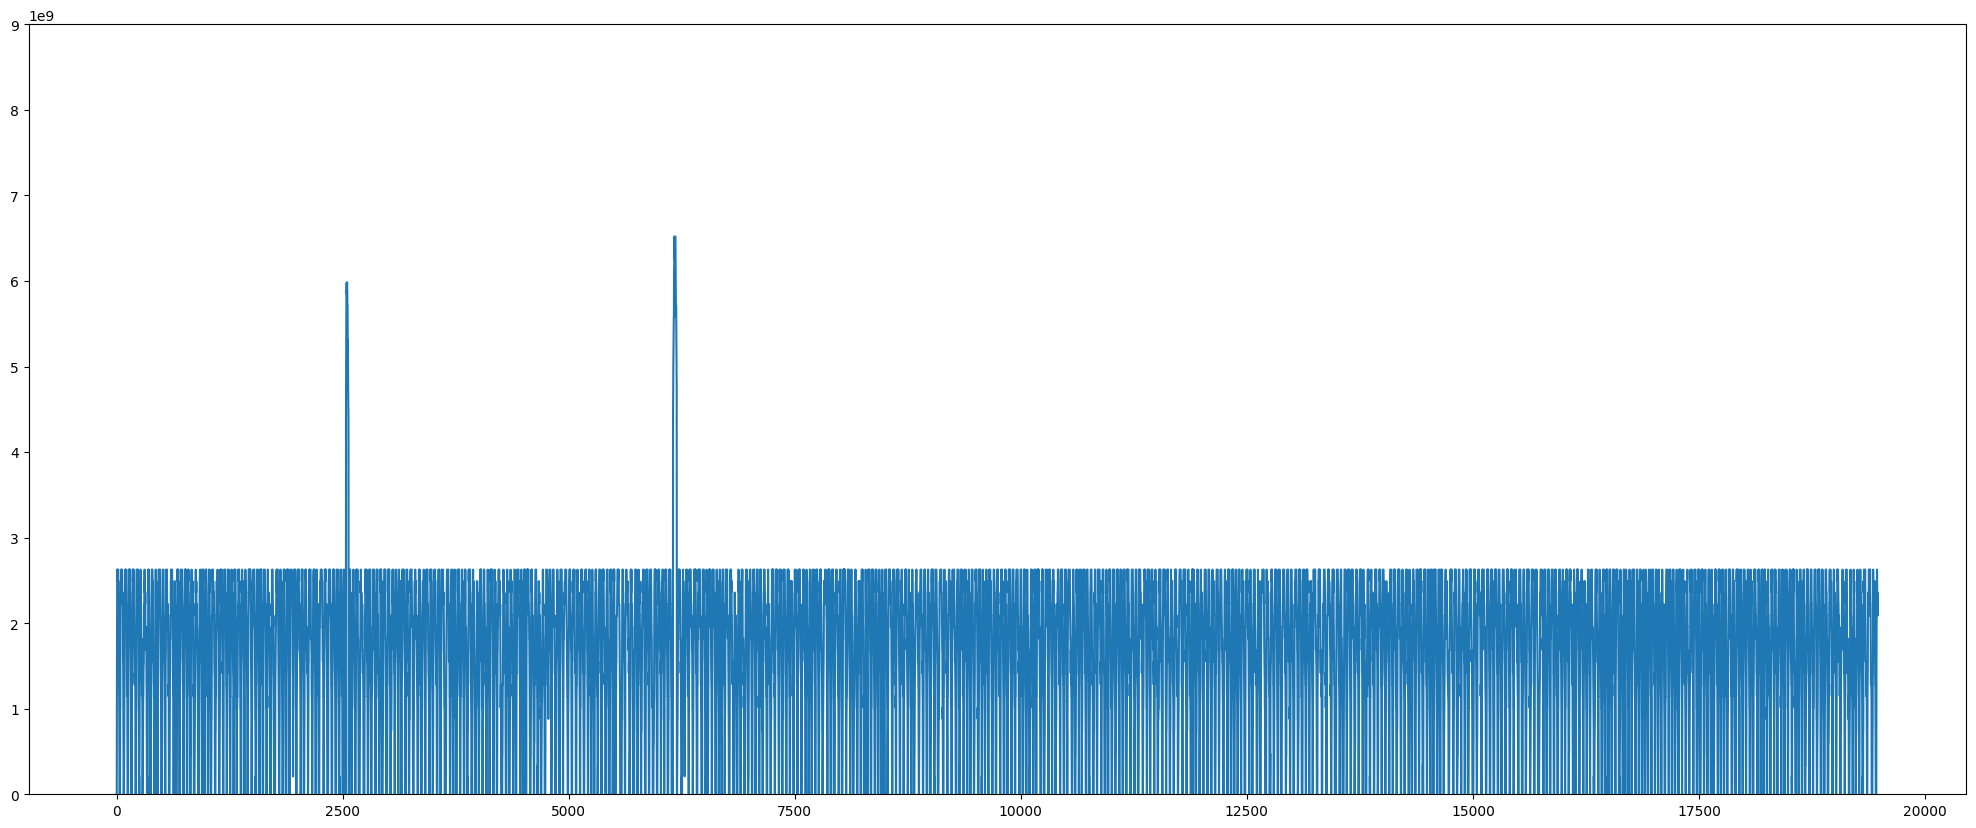

In [36]:
plt.figure(figsize=(25, 10))
plt.plot(df["node_mem_req_aj-aung-k8s-worker2"])
plt.ylim(0, (9 * (10**9)))
plt.show()

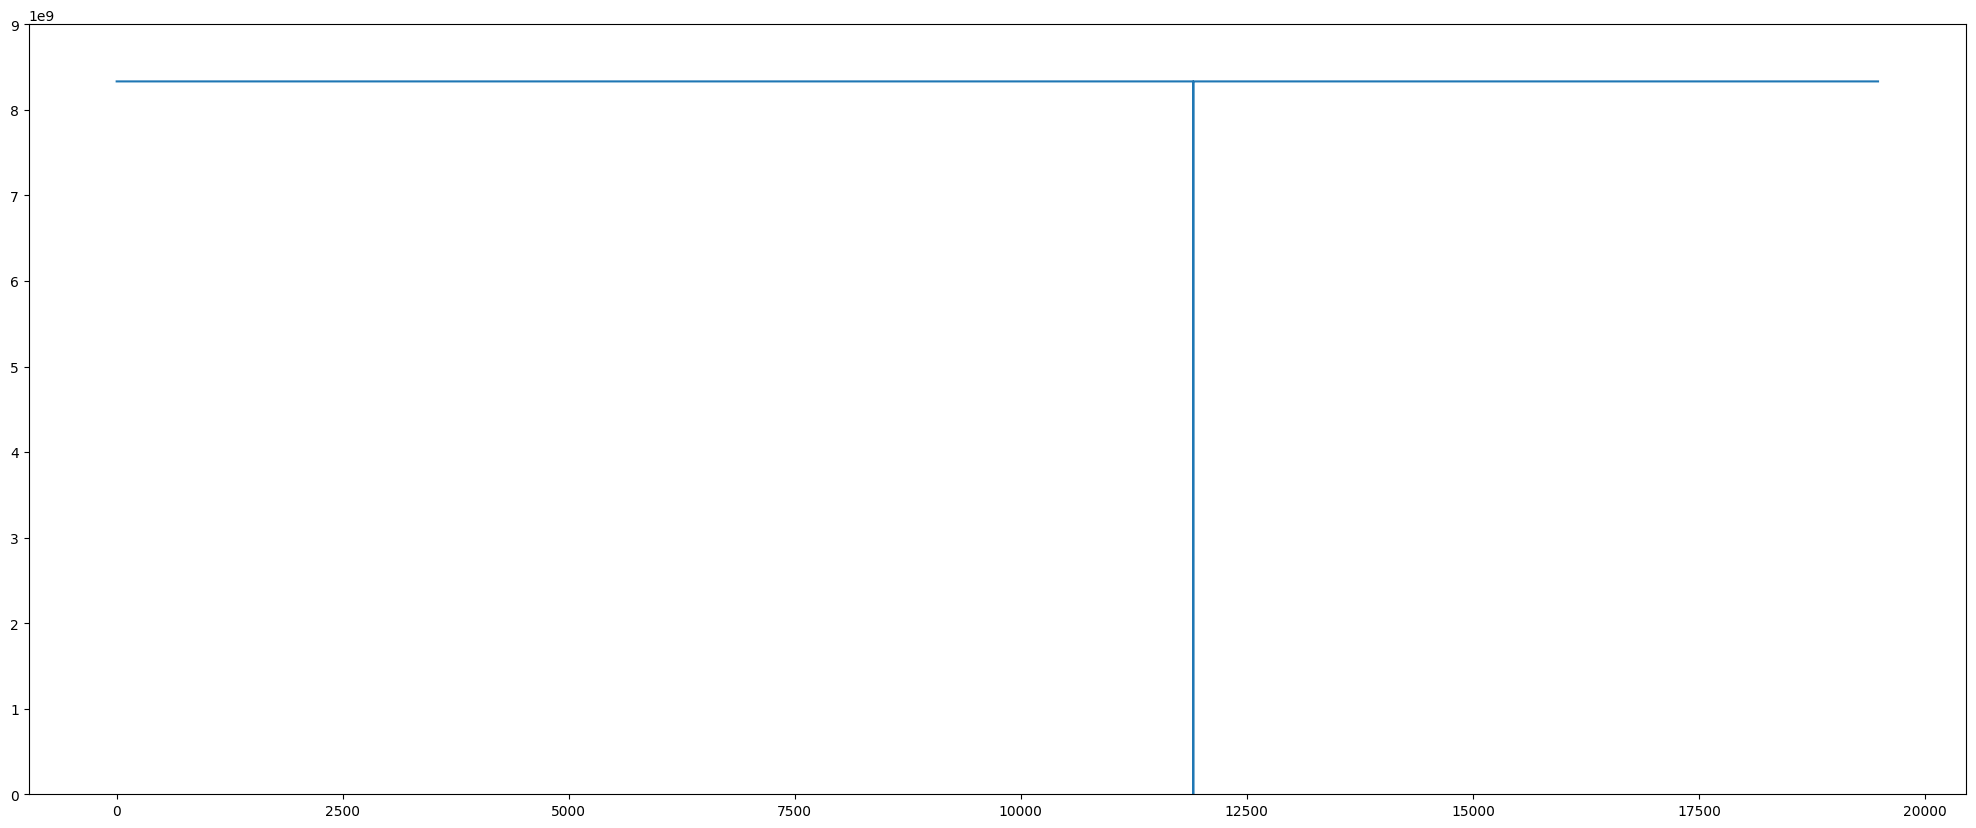

In [37]:
plt.figure(figsize=(25, 10))
plt.plot(df["node_mem_cap_aj-aung-k8s-worker1"])
plt.ylim(0, (9 * (10**9)))
plt.show()

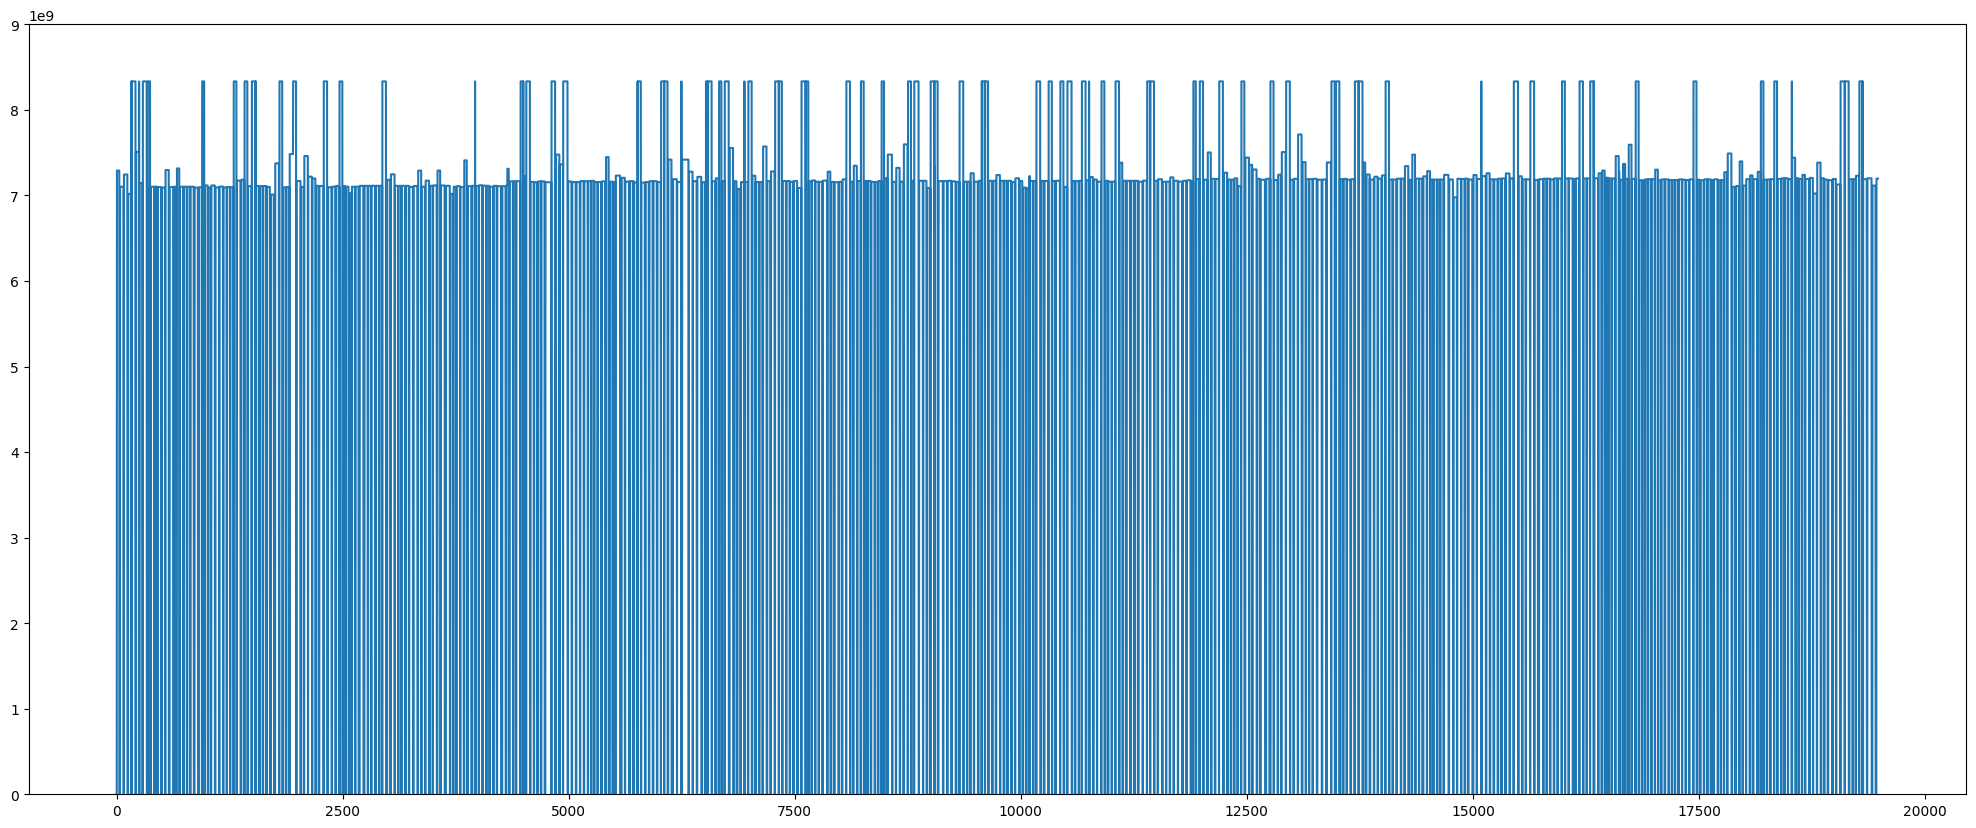

In [38]:
plt.figure(figsize=(25, 10))
plt.plot(df["node_mem_cap_aj-aung-k8s-worker2"])
plt.ylim(0, (9 * (10**9)))
plt.show()

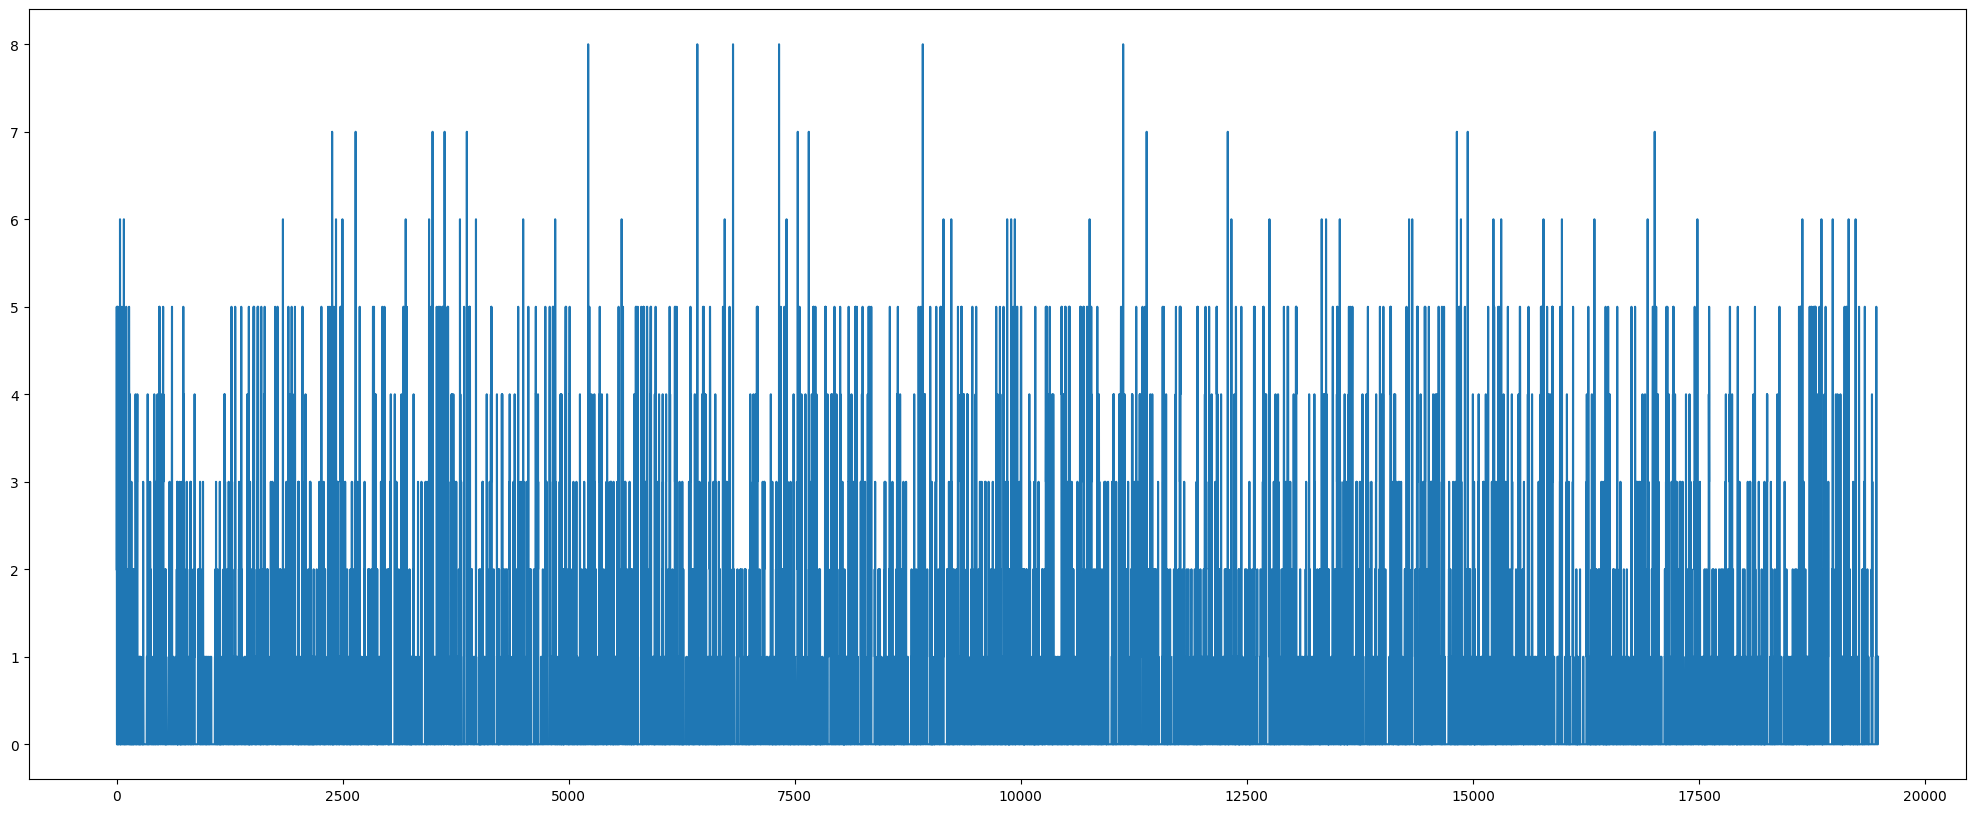

In [39]:
plt.figure(figsize=(25, 10))
plt.plot(df["cluster_pods_pending"])
plt.show()

In [40]:
# =====================================================================
# SETUP & DATA LOADING
# =====================================================================

cluster_cpu_req = pd.DataFrame(
    {'cluster_cpu_req': df['node_cpu_req_aj-aung-k8s-worker1'] + df['node_cpu_req_aj-aung-k8s-worker2']}
)

cluster_cpu_cap = pd.DataFrame(
    {'cluster_cpu_cap': df['node_cpu_cap_aj-aung-k8s-worker1'] + df['node_cpu_cap_aj-aung-k8s-worker2']}
)

cluster_mem_req = pd.DataFrame(
    {'cluster_mem_req': df['node_mem_req_aj-aung-k8s-worker1'] + df['node_mem_req_aj-aung-k8s-worker2']}
)

cluster_mem_cap = pd.DataFrame(
    {'cluster_mem_cap': df['node_mem_cap_aj-aung-k8s-worker1'] + df['node_mem_cap_aj-aung-k8s-worker2']}
)

features = pd.concat([cluster_cpu_req, cluster_cpu_cap, cluster_mem_req, cluster_mem_cap, df['cluster_pods_pending']], axis=1)

target = cluster_cpu_req

raw_data = features.to_numpy()
target_data = target.to_numpy().reshape(-1, 1)

In [41]:
features

,cluster_cpu_req,cluster_cpu_cap,cluster_mem_req,cluster_mem_cap,cluster_pods_pending
0,3.95,4.0,2.638217e+09,8.332227e+09,2.0
1,3.95,4.0,2.638217e+09,8.332227e+09,5.0
2,5.60,8.0,3.787457e+09,1.562216e+10,0.0
3,6.00,8.0,4.055892e+09,1.562216e+10,0.0
4,6.60,8.0,4.458545e+09,1.562216e+10,0.0
...,...,...,...,...,...
19477,6.60,8.0,4.458545e+09,1.552779e+10,0.0
19478,6.60,8.0,4.458545e+09,1.552779e+10,0.0
19479,6.60,8.0,4.458545e+09,1.552779e+10,0.0
19480,6.60,8.0,4.458545e+09,1.552779e+10,0.0


In [42]:
target

,cluster_cpu_req
0,3.95
1,3.95
2,5.60
3,6.00
4,6.60
...,...
19477,6.60
19478,6.60
19479,6.60
19480,6.60


In [43]:
# =====================================================================
# CHRONOLOGICAL SPLIT (70/15/15)
# =====================================================================

n = len(raw_data)
train_idx = int(n * 0.7)
val_idx = int(n * 0.85)

# Split features (for X)
X_train_raw = raw_data[:train_idx]
X_val_raw = raw_data[train_idx:val_idx]
X_test_raw = raw_data[val_idx:]

# Split target (for y)
y_train_raw = target_data[:train_idx]
y_val_raw = target_data[train_idx:val_idx]
y_test_raw = target_data[val_idx:]

In [44]:
# =====================================================================
# DUAL SCALING (CRITICAL STEP)
# =====================================================================

# Scaler 1: For Inputs (Scales CPU, Mem, Pods together)
scaler_inputs = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_inputs.fit_transform(X_train_raw)
X_val_scaled = scaler_inputs.transform(X_val_raw)
X_test_scaled = scaler_inputs.transform(X_test_raw)

# Scaler 2: For Target (Scales ONLY CPU)
scaler_target = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_target.fit_transform(y_train_raw)
y_val_scaled = scaler_target.transform(y_val_raw)
y_test_scaled = scaler_target.transform(y_test_raw)

# SAVE BOTH SCALERS IMMEDIATELY
joblib.dump(scaler_inputs, PROJECT_PATH+'/Multi-Variable/Multi-Var_Scaler_Inputs.pkl')
joblib.dump(scaler_inputs, PROJECT_PATH+'/Multi-Variable/Multi-Var_Scaler_Target.pkl')
print("Success: Both scalers saved.")

Success: Both scalers saved.


In [45]:
# =====================================================================
# SLIDING WINDOW (MULTIVARIATE)
# =====================================================================

# Window Size 30 Minutes # Forecast 5 Minutes
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Gather all features for the window
        data.append(dataset[indices])
        # Gather only the target for the label
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

# Create the 3D arrays
# Note: We pass the SCALED data here
X_train, y_train = multivariate_data(X_train_scaled, y_train_scaled, 0, None, WINDOW_SIZE, FORECAST_HORIZON)
X_val, y_val = multivariate_data(X_val_scaled, y_val_scaled, 0, None, WINDOW_SIZE, FORECAST_HORIZON)
X_test, y_test = multivariate_data(X_test_scaled, y_test_scaled, 0, None, WINDOW_SIZE, FORECAST_HORIZON)

print(f"Train Shape: {X_train.shape}")
print(f"Target Shape: {y_train.shape}")

Train Shape: (13602, 30, 5)
Target Shape: (13602, 1)


In [46]:
# =====================================================================
# KERAS TUNER
# =====================================================================

def build_model(hp):
    model = Sequential()

    hp_units_1 = hp.Int('units_layer_1', min_value=16, max_value=128, step=16)
    num_layers = hp.Int('num_layers', 1, 2)
    return_seq = True if num_layers == 2 else False

    model.add(LSTM(units=hp_units_1, return_sequences=return_seq, input_shape=(X_train.shape[1], X_train.shape[2])))

    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    if num_layers == 2:
        hp_units_2 = hp.Int('units_layer_2', min_value=16, max_value=64, step=16)
        model.add(LSTM(units = hp_units_2, return_sequences = False))
        model.add(Dropout(hp_dropout))

    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse', metrics=['mae'])

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory=PROJECT_PATH+'/Multi-Variable/Tuning',
    project_name=PROJECT_NAME
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nStarting the hyperparameter search...")
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/Old-Dataset-Training/Multi-Variable/Tuning/LSTM_Multi-Variable_CPU_Request/tuner0.json

Starting the hyperparameter search...


In [47]:
# =====================================================================
# BUILD, TRAIN, LOG, AND SAVE THE BEST MODEL
# =====================================================================
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Log the Hyperparameters
with open(PROJECT_PATH + "/Multi-Variable/Best_Hyperparameters.log", "w") as log_file:
    log_file.write("--- Optimal KerasTuner Hyperparameters ---\n")
    for param, value in best_hps.values.items():
        log_file.write(f"{param}: {value}\n")
print("\nSuccess: Hyperparameters logged to 'Best_Hyperparameters.log'")

# Build and train ONE final time
print("Training the final optimal model...")
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=2)

best_model.save(PROJECT_PATH+"/Multi-Variable/Best_Multi_Var_Model.keras")
print("Success: Model saved to 'Best_Multi_Var_Model.keras'")


Success: Hyperparameters logged to 'Best_Hyperparameters.log'
Training the final optimal model...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


426/426 - 16s - 39ms/step - loss: 0.0146 - mae: 0.0746 - val_loss: 0.0039 - val_mae: 0.0502
Epoch 2/100
426/426 - 13s - 30ms/step - loss: 0.0048 - mae: 0.0537 - val_loss: 0.0048 - val_mae: 0.0549
Epoch 3/100
426/426 - 13s - 32ms/step - loss: 0.0044 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0485
Epoch 4/100
426/426 - 13s - 32ms/step - loss: 0.0039 - mae: 0.0483 - val_loss: 0.0034 - val_mae: 0.0467
Epoch 5/100
426/426 - 13s - 30ms/step - loss: 0.0038 - mae: 0.0474 - val_loss: 0.0029 - val_mae: 0.0422
Epoch 6/100
426/426 - 13s - 32ms/step - loss: 0.0036 - mae: 0.0458 - val_loss: 0.0033 - val_mae: 0.0430
Epoch 7/100
426/426 - 13s - 31ms/step - loss: 0.0035 - mae: 0.0456 - val_loss: 0.0033 - val_mae: 0.0474
Epoch 8/100
426/426 - 13s - 31ms/step - loss: 0.0034 - mae: 0.0444 - val_loss: 0.0032 - val_mae: 0.0467
Epoch 9/100
426/426 - 20s - 48ms/step - loss: 0.0033 - mae: 0.0437 - val_loss: 0.0032 - val_mae: 0.0443
Epoch 10/100
426/426 - 13s - 32ms/step - loss: 0.0033 - mae: 0.0439 - val_lo

In [48]:
# =====================================================================
# EVALUATION & PLOTTING
# =====================================================================

# The Final Exam: Test on hidden data
print("\nRunning final evaluation on unseen test data...")
scaled_predictions = best_model.predict(X_test)

# Inverse transform to get real vCore counts
real_predictions = scaler_target.inverse_transform(scaled_predictions)
real_actuals = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Official metrics
rmse = np.sqrt(mean_squared_error(real_actuals, real_predictions))
mae = mean_absolute_error(real_actuals, real_predictions)

print("\n--- OFFICIAL AUTOSCALER PERFORMANCE ---")
print(f"Test RMSE: {rmse:.2f} vCores")
print(f"Test MAE:  {mae:.2f} vCores")
print(f"On average, the model's 5-minute forecast is off by {mae:.2f} vCores.")


Running final evaluation on unseen test data...
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- OFFICIAL AUTOSCALER PERFORMANCE ---
Test RMSE: 0.79 vCores
Test MAE:  0.62 vCores
On average, the model's 5-minute forecast is off by 0.62 vCores.


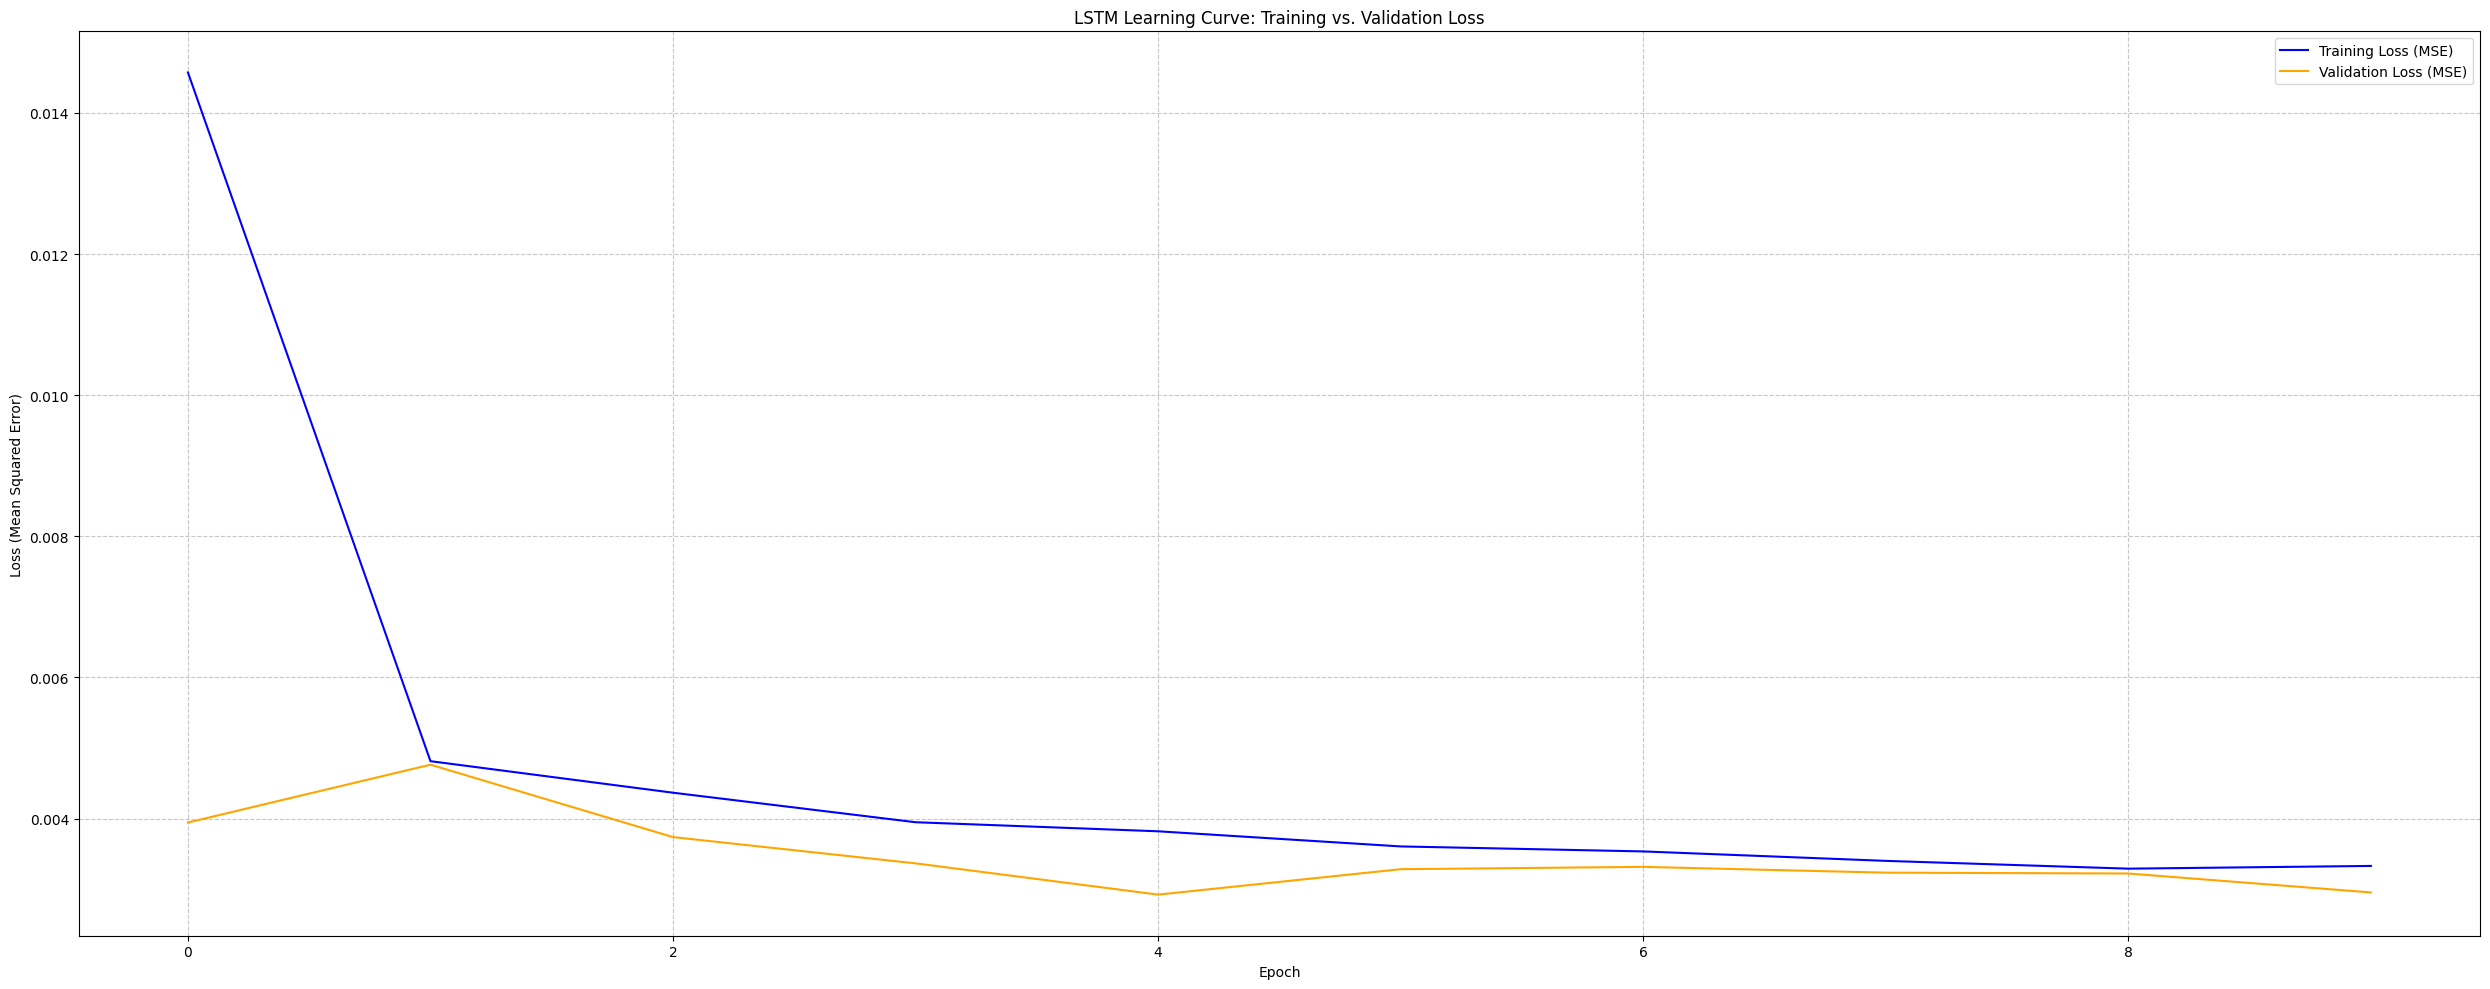

In [49]:
plt.figure(figsize=(25, 10))
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', color='orange')
plt.title('LSTM Learning Curve: Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

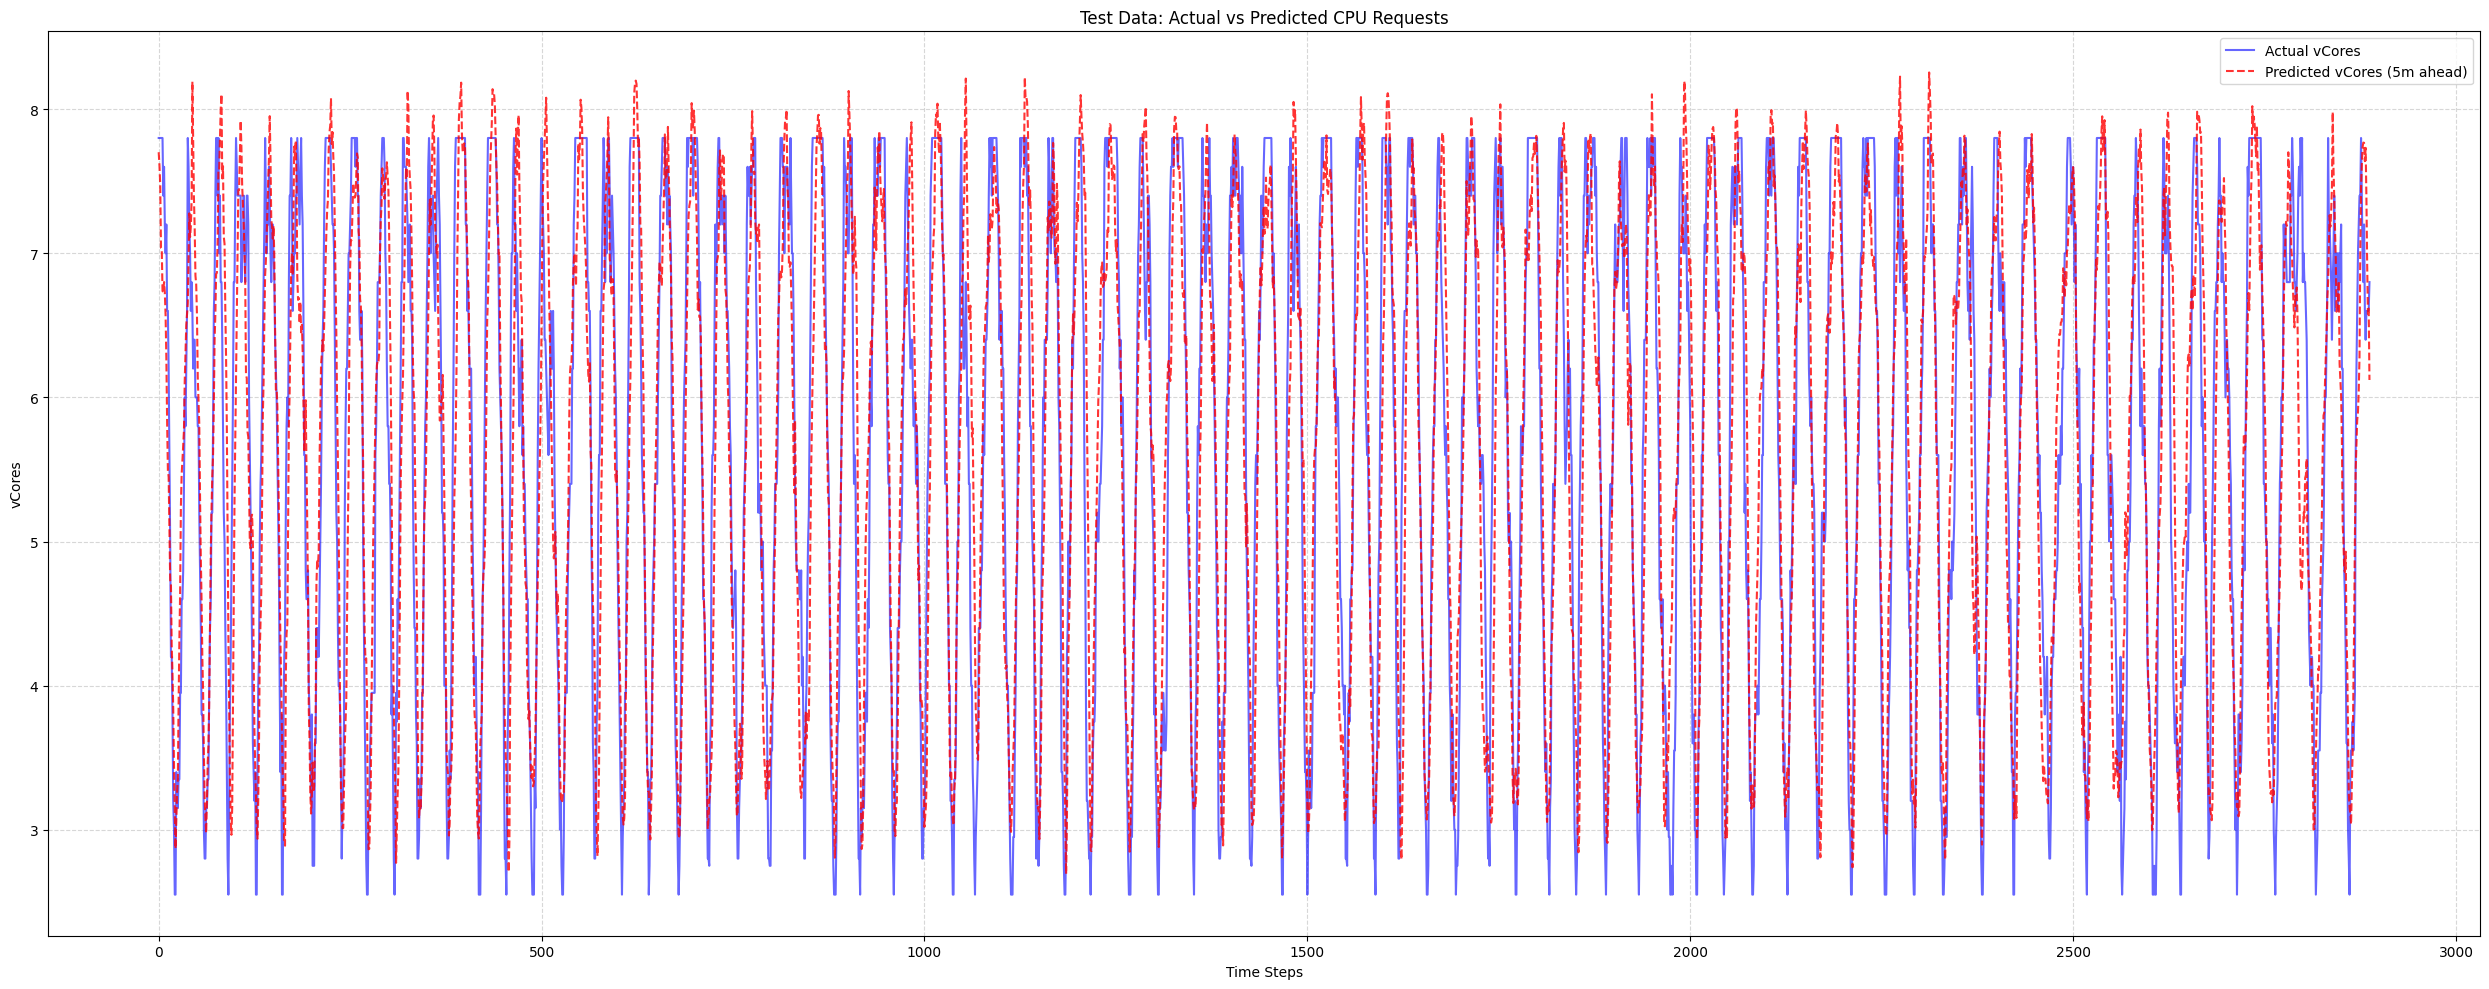

In [50]:
plt.figure(figsize=(25, 10))
plt.plot(real_actuals, label='Actual vCores', color='blue', alpha=0.6)
plt.plot(real_predictions, label='Predicted vCores (5m ahead)', color='red', linestyle='--', alpha=0.8)
plt.title('Test Data: Actual vs Predicted CPU Requests')
plt.xlabel('Time Steps')
plt.ylabel('vCores')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()